# Exploration06 - 영화리뷰 텍스트 감성 분석하기

[Naver sentiment movie corpus](https://github.com/e9t/nsmc)를 이용하여 한국어 텍스트 감정 분석을 해보자.

---

### 루브릭 평가 기준

1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현 - 3가지 이상의 모델이 성공적으로 시도되었나
2. gensim을 활용한 자체학습된 혹은 사전학습된 임베딩 레이어 분석 - gensim의 유사 단어 찾기를 활용하여 자체 학습한 임베딩과 사전학습 임베딩을 적절히 분석하였나
3. 한국어 Word2Vec을 활용한 성능 향상 - 네이버 영화 리뷰 데이터 감성 분석 정확도를 85%이상 달성하였나

---

### 목차

0) 필요 모듈 import


1) 데이터 로드 및 확인


2) 모델 설계
  - LSTM (RNN)
  - 1-D CNN
  - GlobalMaxPooling1D
   
    
3) 학습 및 결과 확인
  - LSTM
  - 1-D CNN
  - GlobalMaxPooling1D


4) 임베딩 레이어 분석
  - 자체 학습된 임베딩 레이어
  - 사전 학습된 임베딩 레이어
  

5) 성능 향상


6) 회고


7) 참고자료

## 0. 필요 모듈 import

In [1]:
import pandas as pd
import os

from tensorflow import keras

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

import re

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# Early Stopping 구현을 위한 함수
from keras.callbacks import EarlyStopping

# Embedding 레이어 분석을 위해
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant
from gensim.models import Word2Vec

## 1. 데이터 로드 및 확인

데이터 전처리 과정을 포함한 데이터 로더를 만들고 불러온 데이터를 확인해보자.

In [2]:
data_dir = os.getcwd() + '/data'

train_data = pd.read_table(data_dir + '/ratings_train.txt')
test_data = pd.read_table(data_dir + '/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


#### * 데이터로더에서는 아래와 같은 전처리 과정을 포함한다.

- 데이터 중복 제거
- 결측치 제거
- 토큰화
- 불용어 제거
- 사전 저장 (word to index)

In [3]:
tokenizer = Mecab() #konlpy의 형태소 분석기

# 불용어
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=12000):

    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복 제거
    train_data = train_data.dropna(how = 'any')  # 결측치 제거        
    
    test_data.drop_duplicates(subset=['document'], inplace=True) 
    test_data = test_data.dropna(how = 'any')
    
    hangul = re.compile('[^ ㄱ-ㅣ가-힣+]') # 한글과 띄어쓰기를 제외한 모든 글자

    X_train = []
    for sentence in train_data['document']:
        new_sentence = hangul.sub('', sentence) # 한글과 띄어쓰기를 제외한 모든 부분을 제거
        temp_X = tokenizer.morphs(new_sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        new_sentence = hangul.sub('', sentence) # 한글과 띄어쓰기를 제외한 모든 부분을 제거
        temp_X = tokenizer.morphs(new_sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(12000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter] # 딕셔너리 맨 앞 인덱스 사전 정의
    word_to_index = {word:index for index, word in enumerate(vocab)} # {텍스트:인덱스} 구조로 저장
    
    # 텍스트를 단어 사전 인덱스로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [4]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

print("number of train data :", len(X_train))
print("number of test data :", len(X_test))

number of train data : 146182
number of test data : 49157


In [5]:
# {인덱스:텍스트} 형태로 순서 변경
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [7]:
# train data의 기본 전처리가 잘 되었는지 확인
for i in range(5):
    print(X_train[i])
    print(get_decoded_sentence(X_train[i], index_to_word))
    print("Label :", y_train[i])
    print("-"*100) # 구분선

[27, 67, 901, 33, 214, 15, 28, 700]
더 빙 진짜 짜증 나 네요 목소리
Label : 0
----------------------------------------------------------------------------------------------------
[978, 481, 491, 637, 4, 110, 1555, 48, 867, 950, 11, 38, 364]
포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 지 않 구나
Label : 1
----------------------------------------------------------------------------------------------------
[19, 192, 2]
재 <UNK>
Label : 0
----------------------------------------------------------------------------------------------------
[8038, 143, 4135, 277, 85, 13, 5, 52, 3327]
이야기 구먼 솔직히 재미 없 다 평점 조정
Label : 0
----------------------------------------------------------------------------------------------------
[2, 8490, 1052, 48, 2703, 54, 4, 2626, 34, 1119, 29, 326, 36, 17, 35, 54, 2, 2, 393, 2851, 1678, 5]
익살 스런 연기 돋보였 던 영화 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNK> <UNK> 너무나 이뻐 보였 다
Label : 1
----------------------------------------------------------------------------------------------------


#### * 너무 긴 문장은 과도한 패딩을 만드므로 2SD rule로 문장의 최대 길이를 정해보자.

In [8]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 정한다. (정규분포 기준 95%)
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)

print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {:.2f}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens) * 100))

문장길이 평균 :  13.721811824571642
문장길이 최대 :  83
문장길이 표준편차 :  11.471373099242314
pad_sequences maxlen :  36
전체 문장의 93.40%가 maxlen 설정값 이내에 포함됩니다. 


위에서 정한 최대 길이를 기준으로 그보다 짧은 문장에 패딩을 더해 입력 데이터의 길이를 맞춰준다.  
RNN은 가장 마지막 입력이 최종 state 값에 영향을 많이 미치므로 의미 없는 패딩은 앞쪽에 채워주는 것이 더 유리하다.  
그러므로 padding 옵션을 'pre'로 설정하였다.

In [9]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 36)


## 2. 모델 설계

3가지 모델을 설계해보자.

1. LSTM (RNN)  
   RNN의 일종으로 기존 RNN의 그레디언트 소실 문제를 방지한다.


2. 1-D CNN  
   문장을 한꺼번에 n 크기의 필터로 스캔하면서 n단어 이내에서 발견된 특징으로 문장을 분류한다.
   
   
3. GlobalMaxPooling1D  
   전체 문장 중 단 하나의 가장 중요한 단어만 추출하여 긍정/부정을 평가한다.

In [10]:
vocab_size = 12000    # 어휘 사전의 크기
word_vector_dim = 20 # 워드 벡터의 차원수

### - LSTM

In [11]:
model_1 = keras.Sequential()
model_1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1.add(keras.layers.LSTM(64))   # 가장 널리 쓰이는 RNN인 LSTM 레이어 사용
model_1.add(keras.layers.Dense(8, activation='relu'))
model_1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 20)          240000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                21760     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 262,289
Trainable params: 262,289
Non-trainable params: 0
_________________________________________________________________


### - 1-D CNN

In [12]:
model_2 = keras.Sequential()
model_2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(keras.layers.Conv1D(16, 5, activation='relu'))
model_2.add(keras.layers.MaxPooling1D(5))
model_2.add(keras.layers.Conv1D(16, 5, activation='relu'))
model_2.add(keras.layers.GlobalMaxPooling1D())
model_2.add(keras.layers.Dense(8, activation='relu'))
model_2.add(keras.layers.Dense(1, activation='sigmoid')) 

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 20)          240000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1616      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1296      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### - GlobalMaxPooling1D

In [13]:
model_3 = keras.Sequential()
model_3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_3.add(keras.layers.GlobalMaxPooling1D())
model_3.add(keras.layers.Dense(8, activation='relu'))
model_3.add(keras.layers.Dense(1, activation='sigmoid'))
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 20)          240000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 240,177
Trainable params: 240,177
Non-trainable params: 0
_________________________________________________________________


## 3. 학습 및 결과 확인

모델 학습 전, train data 중 20%를 validation data로 분리해준다. 

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.2,
                                                  random_state=42)

print('number of train data :', len(X_train))
print('number of validation data :', len(X_val))

number of train data : 116945
number of validation data : 29237


학습이 적당히 진행되면 스스로 멈출 수 있도록 Early Stopping을 설정해준다.  
기본 epoch은 20으로 잡고 val_loss가 최소가 되면 멈추도록한다.

In [15]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

EPOCHS = 30

### - LSTM

In [16]:
model_1.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

history1 = model_1.fit(X_train,
                       y_train,
                       epochs=EPOCHS,
                       batch_size=512,
                       validation_data=(X_val, y_val),
                       callbacks=[es],
                       verbose=1)

Epoch 1/30
229/229 [==============================] - 5s 8ms/step - loss: 0.4887 - accuracy: 0.7562 - val_loss: 0.3701 - val_accuracy: 0.8375
Epoch 2/30
229/229 [==============================] - 1s 6ms/step - loss: 0.3427 - accuracy: 0.8521 - val_loss: 0.3594 - val_accuracy: 0.8409
Epoch 3/30
229/229 [==============================] - 1s 6ms/step - loss: 0.3209 - accuracy: 0.8644 - val_loss: 0.3621 - val_accuracy: 0.8407
Epoch 4/30
229/229 [==============================] - 1s 6ms/step - loss: 0.3067 - accuracy: 0.8711 - val_loss: 0.3647 - val_accuracy: 0.8399
Epoch 5/30
229/229 [==============================] - 1s 6ms/step - loss: 0.2937 - accuracy: 0.8777 - val_loss: 0.3690 - val_accuracy: 0.8406
Epoch 00005: early stopping


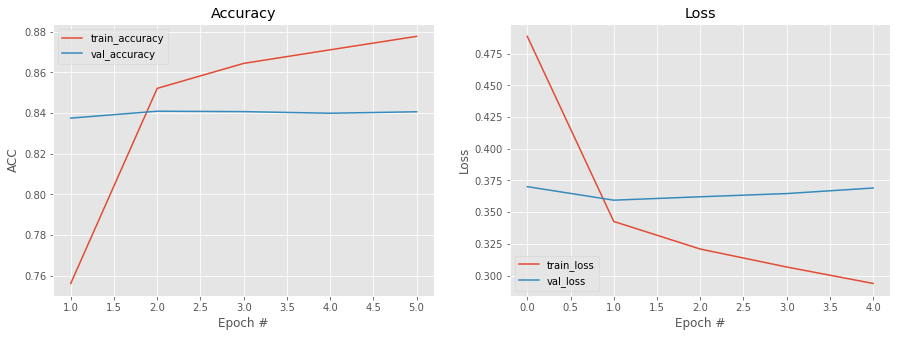

In [17]:
N = len(history1.history["accuracy"])

plt.figure(figsize=(15, 5))

plt.style.use("ggplot")
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, N+1), history1.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(1, N+1), history1.history["val_accuracy"], label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("ACC")
plt.legend(loc="upper left")

plt.style.use("ggplot")
plt.subplot(1, 2, 2)
plt.plot(np.arange(0, N), history1.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history1.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")


In [18]:
result1 = model_1.evaluate(X_test, y_test, verbose=2)

print('LSTM 모델의 정확도 : {:.2f}%'.format(result1[1]*100))

1537/1537 - 3s - loss: 0.3719 - accuracy: 0.8406
LSTM 모델의 정확도 : 84.06%


### - 1-D CNN

In [19]:
model_2.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

history2 = model_2.fit(X_train,
                       y_train,
                       epochs=EPOCHS,
                       batch_size=512,
                       validation_data=(X_val, y_val),
                       callbacks=[es],
                       verbose=1)

Epoch 1/30
229/229 [==============================] - 3s 6ms/step - loss: 0.5721 - accuracy: 0.6855 - val_loss: 0.4482 - val_accuracy: 0.7824
Epoch 2/30
229/229 [==============================] - 1s 5ms/step - loss: 0.4068 - accuracy: 0.8094 - val_loss: 0.4241 - val_accuracy: 0.7956
Epoch 3/30
229/229 [==============================] - 1s 5ms/step - loss: 0.3612 - accuracy: 0.8354 - val_loss: 0.4304 - val_accuracy: 0.7935
Epoch 4/30
229/229 [==============================] - 1s 5ms/step - loss: 0.3238 - accuracy: 0.8554 - val_loss: 0.4387 - val_accuracy: 0.7959
Epoch 5/30
229/229 [==============================] - 1s 5ms/step - loss: 0.2861 - accuracy: 0.8744 - val_loss: 0.4614 - val_accuracy: 0.7928
Epoch 00005: early stopping


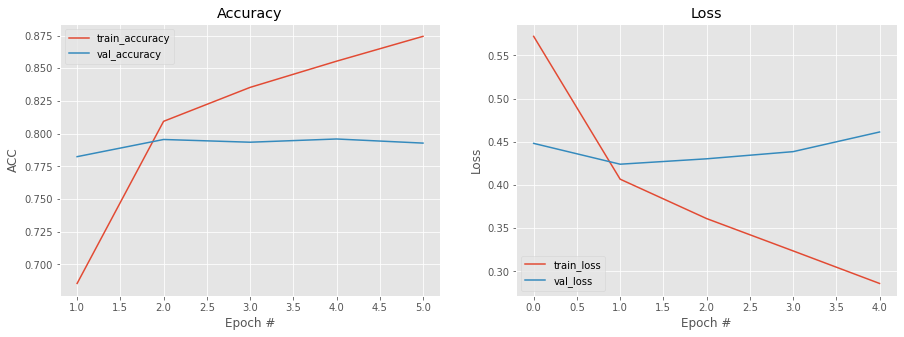

In [20]:
N = len(history2.history["accuracy"])

plt.figure(figsize=(15, 5))

plt.style.use("ggplot")
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, N+1), history2.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(1, N+1), history2.history["val_accuracy"], label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("ACC")
plt.legend(loc="upper left")

plt.style.use("ggplot")
plt.subplot(1, 2, 2)
plt.plot(np.arange(0, N), history2.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history2.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

In [21]:
result2 = model_2.evaluate(X_test, y_test, verbose=2)

print('1-D CNN 모델의 정확도 : {:.2f}%'.format(result2[1]*100))

1537/1537 - 3s - loss: 0.4689 - accuracy: 0.7932
1-D CNN 모델의 정확도 : 79.32%


### - GlobalMaxPooling1D( )

In [22]:
model_3.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

history3 = model_3.fit(X_train,
                       y_train,
                       epochs=EPOCHS,
                       batch_size=512,
                       validation_data=(X_val, y_val),
                       callbacks=[es],
                       verbose=1)

Epoch 1/30
229/229 [==============================] - 1s 4ms/step - loss: 0.6009 - accuracy: 0.7620 - val_loss: 0.4607 - val_accuracy: 0.8151
Epoch 2/30
229/229 [==============================] - 1s 3ms/step - loss: 0.3965 - accuracy: 0.8338 - val_loss: 0.3774 - val_accuracy: 0.8326
Epoch 3/30
229/229 [==============================] - 1s 3ms/step - loss: 0.3390 - accuracy: 0.8566 - val_loss: 0.3631 - val_accuracy: 0.8375
Epoch 4/30
229/229 [==============================] - 1s 3ms/step - loss: 0.3087 - accuracy: 0.8709 - val_loss: 0.3607 - val_accuracy: 0.8405
Epoch 5/30
229/229 [==============================] - 1s 3ms/step - loss: 0.2859 - accuracy: 0.8821 - val_loss: 0.3644 - val_accuracy: 0.8400
Epoch 6/30
229/229 [==============================] - 1s 3ms/step - loss: 0.2669 - accuracy: 0.8908 - val_loss: 0.3705 - val_accuracy: 0.8390
Epoch 7/30
229/229 [==============================] - 1s 3ms/step - loss: 0.2507 - accuracy: 0.8988 - val_loss: 0.3799 - val_accuracy: 0.8385
Epoch 

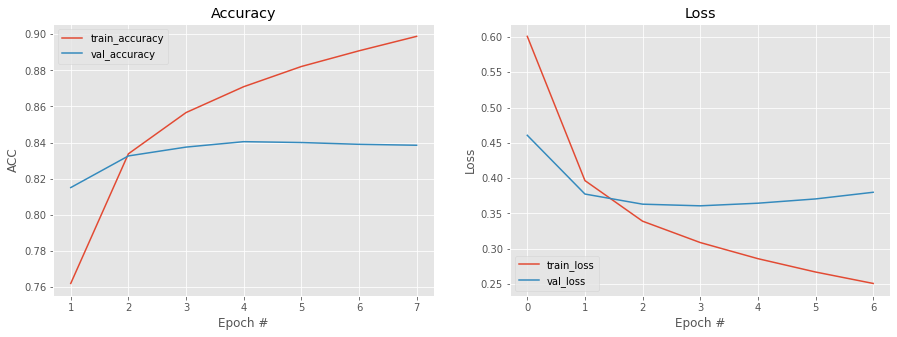

In [23]:
N = len(history3.history["accuracy"])

plt.figure(figsize=(15, 5))

plt.style.use("ggplot")
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, N+1), history3.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(1, N+1), history3.history["val_accuracy"], label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("ACC")
plt.legend(loc="upper left")

plt.style.use("ggplot")
plt.subplot(1, 2, 2)
plt.plot(np.arange(0, N), history3.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history3.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

In [24]:
result3 = model_3.evaluate(X_test, y_test, verbose=2)

print('GlobalMaxPooling1D 모델의 정확도 : {:.2f}%'.format(result3[1]*100))

1537/1537 - 2s - loss: 0.3846 - accuracy: 0.8373
GlobalMaxPooling1D 모델의 정확도 : 83.73%


## 4. 임베딩 레이어 분석

위에서 학습한 세 모델중 가장 성능이 좋았던 LSTM의 임베딩 레이어와 사전 학습된 임베딩 레이어를 불러와 비교해보자.


### - 자체 학습 임베딩 모델

In [25]:
embedding_layer = model_1.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(12000, 20)


In [26]:
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getcwd()+'/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model_1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

처음에 지정한 embedding_dim과 같이 20차원의 벡터가 생성됨을 확인할 수 있다.

In [27]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

vector = word_vectors["호감"]
vector

array([-0.08834302,  0.07414903,  0.06583034, -0.07670746, -0.05744641,
        0.09149243,  0.04072958, -0.03173523,  0.09794082, -0.07395646,
        0.00678959,  0.05586457,  0.08905848,  0.09094919, -0.10163495,
        0.06366432, -0.04833202,  0.02313598, -0.03989377,  0.08594182],
      dtype=float32)

gensim을 사용하여 주어진 단어와 유사한 단어를 확인해보자.

In [28]:
word_vectors.similar_by_word("재미")

[('두뇌', 0.809737503528595),
 ('인거', 0.7862012386322021),
 ('여성', 0.7826333045959473),
 ('천녀', 0.7712928056716919),
 ('메이저', 0.7557326555252075),
 ('도망치', 0.7479588985443115),
 ('존나게', 0.743575394153595),
 ('이다해', 0.7154174447059631),
 ('띄우', 0.7086103558540344),
 ('가스', 0.7068145275115967)]

데이터가 부족했는지 엉뚱한 단어와 유사도가 높다는 판단을 내린다.  
이정도의 학습으로는 워드 벡터가 정교해지기는 힘든 것 같다.  

---

### - 사전 학습된 한국어 임베딩 모델 
한국어 Word2Vec은 [여기](https://github.com/Kyubyong/wordvectors)에서 다운 받아 사용하였다.  

In [29]:
word2vec_path = os.getcwd() + '/word2vec/ko.bin'

word2vec = Word2Vec.load(word2vec_path)

embedding_dim이 200이므로 200차원의 벡터가 출력된다.

In [30]:
vector2 = word2vec["호감"]
vector2

/tmp/ipykernel_909/2335940433.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector2 = word2vec["호감"]


array([-2.91866422e-01, -6.70812801e-02,  1.10413301e+00, -1.12605048e-02,
        5.57538033e-01,  7.58035243e-01, -2.08839223e-01, -1.91374451e-01,
       -9.05053258e-01, -2.30513901e-01,  4.62058961e-01,  2.14382738e-01,
        3.52626443e-01,  5.07661402e-01, -3.16414803e-01,  2.40264446e-01,
        8.71794581e-01,  8.48725736e-02, -1.42473173e+00, -7.27164030e-01,
        2.76912451e-01, -3.21910352e-01,  5.25041461e-01, -6.14396989e-01,
        1.73800513e-01,  1.18187517e-01,  1.31200850e-01,  5.75700104e-01,
       -1.13212931e+00, -4.99994308e-01,  2.44694963e-01, -1.32752788e+00,
        5.23592114e-01, -4.56059366e-01,  6.04127228e-01,  1.91589013e-01,
       -1.93429738e-01, -3.49264771e-01, -1.07368231e+00,  2.88097203e-01,
       -1.00473702e+00, -1.88416671e-02, -3.11161578e-01,  7.93592036e-01,
        7.84846306e-01,  2.00634007e-03,  2.02387476e+00, -1.10321558e+00,
       -1.65068321e-02, -5.51435798e-02, -5.81238985e-01, -3.54389697e-01,
       -2.12916270e-01,  

아까와 같은 단어의 유사 단어를 찾아보자.

In [31]:
word2vec.similar_by_word("재미")

/tmp/ipykernel_909/2795643307.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("재미")


[('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700767755508423),
 ('비애', 0.4836210310459137),
 ('관객', 0.48286449909210205),
 ('향수', 0.4823310971260071)]

자체 학습된 임베딩 모델보다 더 많은 데이터로 사전 학습된 임베딩의 성능이 확실히 좋아보인다.  

## 5. 모델 성능 향상

앞선 과정에서 살펴본 사전 학습된 임베딩 모델을 사용하여 모델의 성능을 향상시켜보자.

In [32]:
vocab_size = 12000    # 어휘 사전의 크기
word_vector_dim = 200 # 워드 벡터의 차원수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_909/3323131563.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_909/3323131563.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [33]:
model_4 = keras.Sequential()
model_4.add(keras.layers.Embedding(vocab_size,
                                      word_vector_dim,
                                      embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                      input_length=maxlen,
                                      trainable=True))   # trainable을 True로 주면 Fine-tuning
model_4.add(keras.layers.LSTM(64))   
model_4.add(keras.layers.Dense(8, activation='relu'))
model_4.add(keras.layers.Dense(1, activation='sigmoid'))

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 36, 200)           2400000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,468,369
Trainable params: 2,468,369
Non-trainable params: 0
_________________________________________________________________


In [34]:
model_4.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

history4 = model_4.fit(X_train,
                       y_train,
                       epochs=EPOCHS,
                       batch_size=512,
                       validation_data=(X_val, y_val),
                       callbacks=[es],
                       verbose=1)

Epoch 1/30
229/229 [==============================] - 3s 10ms/step - loss: 0.4739 - accuracy: 0.7667 - val_loss: 0.3817 - val_accuracy: 0.8293
Epoch 2/30
229/229 [==============================] - 2s 8ms/step - loss: 0.3469 - accuracy: 0.8466 - val_loss: 0.3502 - val_accuracy: 0.8453
Epoch 3/30
229/229 [==============================] - 2s 8ms/step - loss: 0.3015 - accuracy: 0.8712 - val_loss: 0.3396 - val_accuracy: 0.8523
Epoch 4/30
229/229 [==============================] - 2s 8ms/step - loss: 0.2715 - accuracy: 0.8868 - val_loss: 0.3424 - val_accuracy: 0.8550
Epoch 5/30
229/229 [==============================] - 2s 8ms/step - loss: 0.2479 - accuracy: 0.8989 - val_loss: 0.3469 - val_accuracy: 0.8552
Epoch 6/30
229/229 [==============================] - 2s 8ms/step - loss: 0.2244 - accuracy: 0.9099 - val_loss: 0.3533 - val_accuracy: 0.8516
Epoch 00006: early stopping


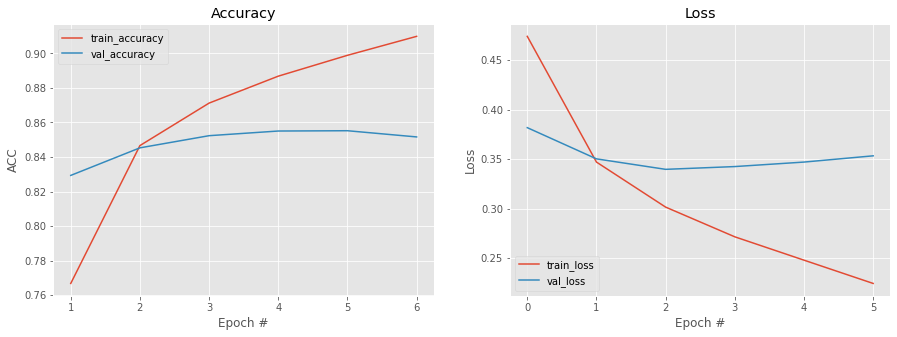

In [35]:
N = len(history4.history["accuracy"])

plt.figure(figsize=(15, 5))

plt.style.use("ggplot")
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, N+1), history4.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(1, N+1), history4.history["val_accuracy"], label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("ACC")
plt.legend(loc="upper left")

plt.style.use("ggplot")
plt.subplot(1, 2, 2)
plt.plot(np.arange(0, N), history4.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history4.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

In [36]:
result4 = model_4.evaluate(X_test, y_test, verbose=2)

print('개선된 LSTM 모델의 정확도 : {:.2f}%'.format(result4[1]*100))

1537/1537 - 3s - loss: 0.3592 - accuracy: 0.8507
개선된 LSTM 모델의 정확도 : 85.07%


#### * 정확도가 85%를 넘었으므로 루브릭 기준 달성 (´▽｀)=b

## 6. 회고

#### - Early Stopping  
E-04의 작사가 노드에서 epoch을 20으로 잡고 돌리는 중 10번째 쯤에서 val_loss가 수렴하는 것을 보았다. 하지만 학습이 너무 오래걸려 중간에 멈출 수가 없었기 때문에 눈물을 머금고 계속 진행시켰던 기억이 있다.  
이번에는 이를 방지하기 위해 초기 학습 횟수는 크게 잡고 val_loss가 수렴하면 학습을 멈추도록 하는 early stopping에 관한 내용을 찾아 구현하였다.  
그런데 작사가 노드만큼 학습 시간이 오래 걸리지는 않아 유의미한 시도는 아니었던 것 같다.
  

#### - 1-D CNN
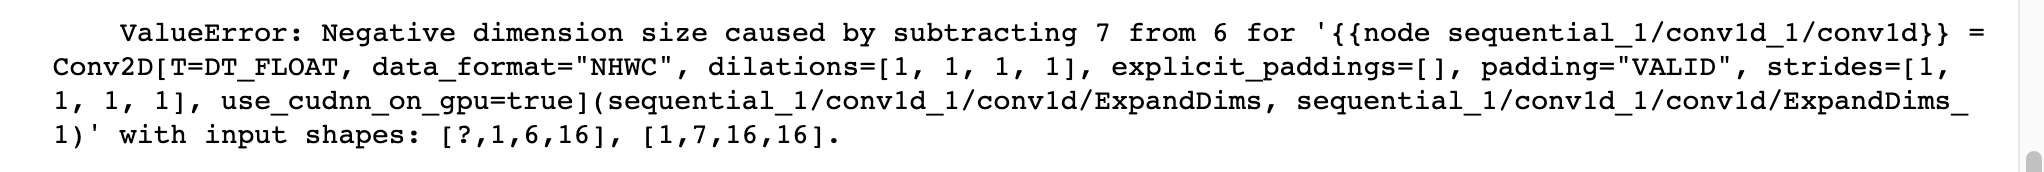
1차원 CNN 모델을 사용할 때, input shape와 관련된 오류가 발생한다.  
어떤 것이 6인지는 모르겠지만 6에 비해 필터 사이즈인 7이 커서 생기는 오류 같아 컨볼루션 필터 사이즈를 5로 줄여주었다.  
오류에 대한 해결은 했지만 원인이 무엇인지, 왜 해결이 된것인지는 아직 찾지 못했다. 


#### - 경고문

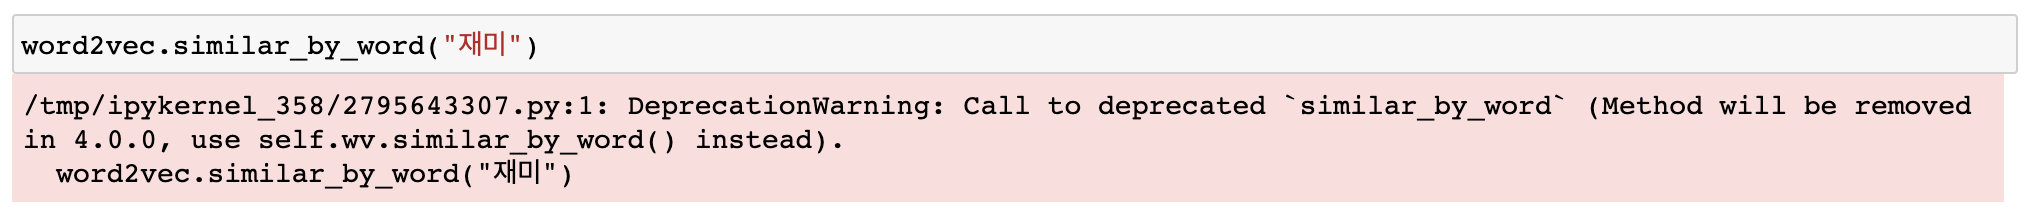
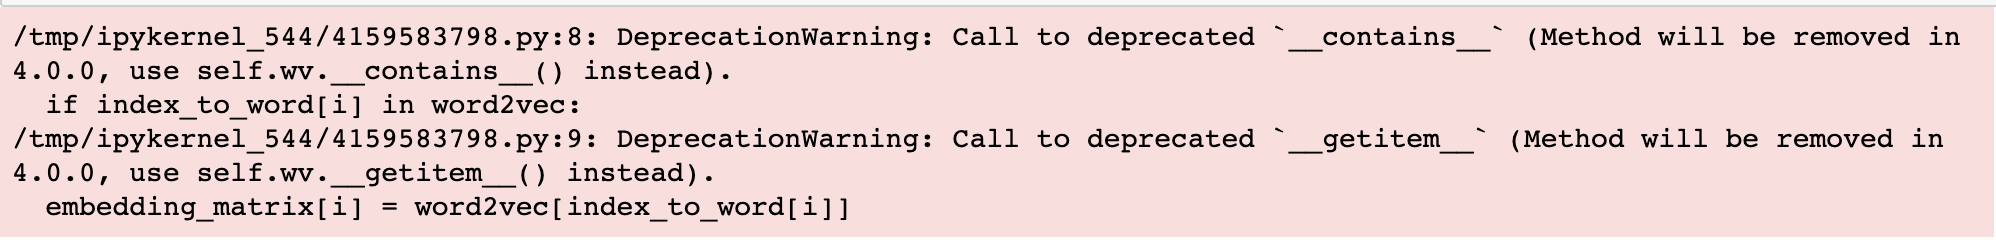
gensim 3.x 버전 사용해서 경고문이 위와 같은 뜬다.  
하나는 직접 수정하여 사용할 수 있고, 하나는 내부함수(?)에서 문제가 되는 듯 했다.  
동작을 하지 않는건 아니라 그냥 두었다.  


#### - 3시그마 규칙
문장의 최대 길이를 정할 때 왜 \(평균 + 2*표준편차) 라는 식을 사용하였는지 궁금했다.  
3시그마 규칙은 경험적인 규칙으로, 약 95\%의 값들이 평균에서 양쪽으로 2 표준편차 범위 내에 존재한다는 의미였다.   
나중에도 크기가 너무 크거나 작은 이상치들을 걸러낼 때 유용하게 사용할 수 있을 것 같다.

## 7. 참고 자료

- 한국어 전처리 기법  
  https://codingspooning.tistory.com/138
  
 
- Early Stopping  
  https://3months.tistory.com/424
  
  
- 3 Sigma rule  
  https://intothedata.com/02.scholar_category/anomaly_detection/3_sigma_rule/